In [704]:
import pandas as pd
import matplotlib.pyplot as mt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree

redWineData = pd.read_csv('./winequality-red.csv', delimiter=';', index_col=False)
#redWineData.describe()

# Wine Alcohol Classification

In [705]:
#Wine Alcohol Classification
#0-9
#9-10
#10-11
#11-12
#gt12
conditionsAlcohol = [
    (redWineData['alcohol'] < 9),
    (redWineData['alcohol'] >= 9) & (redWineData['alcohol'] < 10),
    (redWineData['alcohol'] >= 10) & (redWineData['alcohol'] < 11),
    (redWineData['alcohol'] >= 11) & (redWineData['alcohol'] < 12),
    (redWineData['alcohol'] >= 12)
]
valuesAlcohol = [
    '< 9',
    '9-10',
    '10-11',
    '11-12',
    '12 >'
]
redWineData['alcoholClass'] = np.select(conditionsAlcohol,valuesAlcohol)
redWineData.alcoholClass

0        9-10
1        9-10
2        9-10
3        9-10
4        9-10
        ...  
1594    10-11
1595    11-12
1596    11-12
1597    10-11
1598    11-12
Name: alcoholClass, Length: 1599, dtype: object

In [706]:
#Wine residual sugar classification
# 0-5 -> Low Sugar
# 6-10 -> Medium Sugar
# 11> -> High Sugar
conditionsSugar = [
    (redWineData['residual sugar'] < 2),
    (redWineData['residual sugar'] >= 2) & (redWineData['residual sugar'] < 3),
    (redWineData['residual sugar'] >= 3)
]
valuesSugar = [
    'Low Sugar',
    'Medium Sugar',
    'High Sugar'
]
redWineData['sugarClass'] = np.select(conditionsSugar,valuesSugar)
redWineData.sugarClass.value_counts()


Medium Sugar    895
Low Sugar       464
High Sugar      240
Name: sugarClass, dtype: int64

In [707]:
#3,4,5,6,7,8
#1-4 -> Bad
#5-6 -> Fair
#7 -> Good
#8-10 -> Loyal

redWineData.isnull().sum()
redWineData['is_citric_acid'] = np.where(redWineData['citric acid'] == 0, 'WithoutAcid', 'WithAcid')


conditionsQuality = [
    (redWineData['quality'] < 4),
    (redWineData['quality'] >= 4) & (redWineData['quality'] < 6),
    (redWineData['quality'] >= 6) & (redWineData['quality'] < 7),
    (redWineData['quality'] >= 7)
]
valuesQuality = [
    'Bad',
    'Fair',
    'Good',
    'Loyal'
]
redWineData['qualityClass'] = np.select(conditionsQuality,valuesQuality)
redWineData.qualityClass

0       Fair
1       Fair
2       Fair
3       Good
4       Fair
        ... 
1594    Fair
1595    Good
1596    Good
1597    Fair
1598    Good
Name: qualityClass, Length: 1599, dtype: object

In [708]:
conditionsBQuality = [
    (redWineData['qualityClass'] == 'Good') | (redWineData['qualityClass'] == 'Loyal'),
    (redWineData['qualityClass'] == 'Bad') | (redWineData['qualityClass'] == 'Fair')
]
valuesBQuality = [
    0,
    1
]
redWineData['binaryQualityClass'] = np.select(conditionsBQuality,valuesBQuality)
redWineData.binaryQualityClass.value_counts()


0    855
1    744
Name: binaryQualityClass, dtype: int64

In [709]:
#Wine chlorides classification
# 0-0.1 Low Chlorides
# 0.1-0.2 Medium Chlorides
# 0.2 > High Chlorides

conditionsChlorides = [
    (redWineData['chlorides'] < 0.08),
    (redWineData['chlorides'] >= 0.08) & (redWineData['chlorides'] < 0.1),
    (redWineData['chlorides'] >= 0.1)
]
valuesChlorides = [
    'Low Chlorides',
    'Medium Chlorides',
    'High Chlorides'
]
redWineData['chloridesClass'] = np.select(conditionsChlorides,valuesChlorides)
redWineData.chloridesClass.value_counts()



Low Chlorides       808
Medium Chlorides    555
High Chlorides      236
Name: chloridesClass, dtype: int64

In [710]:
redWineData.groupby(['is_citric_acid']).agg(['count'])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,alcoholClass,sugarClass,qualityClass,binaryQualityClass,chloridesClass
,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count
is_citric_acid,,,,,,,,,,,,,,,,,
WithAcid,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467
WithoutAcid,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132


In [711]:

#Desition tree implementation
#redWineData.head(20)

In [712]:
#Print all the features name

for  i in range(len(redWineData.columns.values)):
    print(i+1, redWineData.columns.values[i])

1 fixed acidity
2 volatile acidity
3 citric acid
4 residual sugar
5 chlorides
6 free sulfur dioxide
7 total sulfur dioxide
8 density
9 pH
10 sulphates
11 alcohol
12 quality
13 alcoholClass
14 sugarClass
15 is_citric_acid
16 qualityClass
17 binaryQualityClass
18 chloridesClass


In [713]:
#See type of feature type
redWineData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
 12  alcoholClass          1599 non-null   object 
 13  sugarClass            1599 non-null   object 
 14  is_citric_acid        1599 non-null   object 
 15  qualityClass         

In [714]:
#Check for a null value
redWineData.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
alcoholClass            0
sugarClass              0
is_citric_acid          0
qualityClass            0
binaryQualityClass      0
chloridesClass          0
dtype: int64

In [715]:
numerical = [f for f in redWineData.columns if redWineData.dtypes[f] != 'object']
categorical = [f for f in redWineData.columns if redWineData.dtypes[f] == 'object']

print("Numerical features:")
for i in range(len(numerical)):
    print(i+1, numerical[i])
print("\nCategorical features:")
for i in range(len(categorical)):
    print(i+1, categorical[i])

Numerical features:
1 fixed acidity
2 volatile acidity
3 citric acid
4 residual sugar
5 chlorides
6 free sulfur dioxide
7 total sulfur dioxide
8 density
9 pH
10 sulphates
11 alcohol
12 quality
13 binaryQualityClass

Categorical features:
1 alcoholClass
2 sugarClass
3 is_citric_acid
4 qualityClass
5 chloridesClass


In [716]:
#Aggregation information
redWineData.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,binaryQualityClass
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023,0.465291
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569,0.498950
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000,0.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1.000000


In [717]:
#Unique values

print("Data Shape: ")
redWineData.shape
n_unique = redWineData.nunique()
print("Number of unique values:\n{}".format(n_unique))

Data Shape: 
Number of unique values:
fixed acidity            96
volatile acidity        143
citric acid              80
residual sugar           91
chlorides               153
free sulfur dioxide      60
total sulfur dioxide    144
density                 436
pH                       89
sulphates                96
alcohol                  65
quality                   6
alcoholClass              5
sugarClass                3
is_citric_acid            2
qualityClass              4
binaryQualityClass        2
chloridesClass            3
dtype: int64


In [718]:
print("Check for NaN value:")
redWineData.isnull().sum()
redWineData['fixed acidity'].fillna('No Fixed Acidity', inplace=True)
redWineData['pH'].fillna('No pH', inplace=True)
print("Make sure are there any NaN value left:")
redWineData.isnull().sum()

Check for NaN value:
Make sure are there any NaN value left:


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
alcoholClass            0
sugarClass              0
is_citric_acid          0
qualityClass            0
binaryQualityClass      0
chloridesClass          0
dtype: int64

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>,
        <AxesSubplot:title={'center':'residual sugar'}>],
       [<AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>,
        <AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>],
       [<AxesSubplot:title={'center':'pH'}>,
        <AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>],
       [<AxesSubplot:title={'center':'binaryQualityClass'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

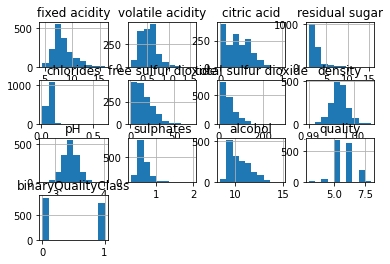

In [719]:
redWineData.hist()

In [720]:
redWineData.qualityClass.value_counts()

Fair     734
Good     638
Loyal    217
Bad       10
Name: qualityClass, dtype: int64

In [721]:
#Features vs Quality Class

In [722]:
def bar_chart(feature):
    bad = redWineData[redWineData['qualityClass'] == 'Bad'][feature].value_counts()
    fair = redWineData[redWineData['qualityClass'] == 'Fair'][feature].value_counts()
    good = redWineData[redWineData['qualityClass'] == 'Good'][feature].value_counts()
    loyal = redWineData[redWineData['qualityClass'] == 'Loyal'][feature].value_counts()
    df = pd.DataFrame([bad,fair,good,loyal])
    df.index = ['Bad', 'Fair','Good','Loyal']
    df.plot(kind='bar',stacked=True, figsize=(10,10))

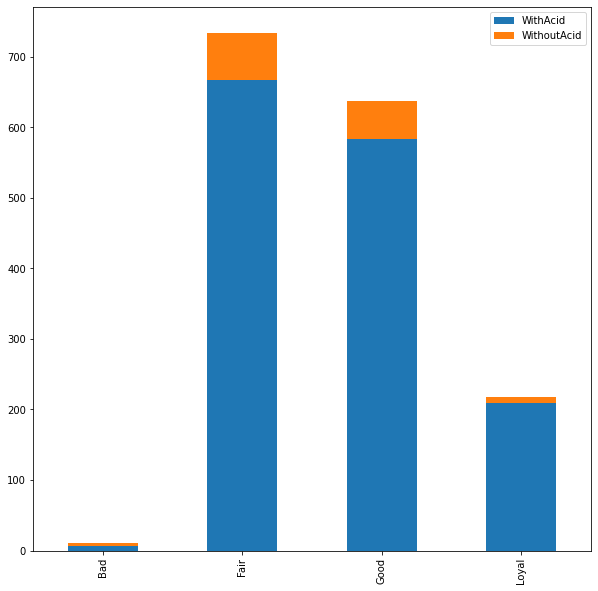

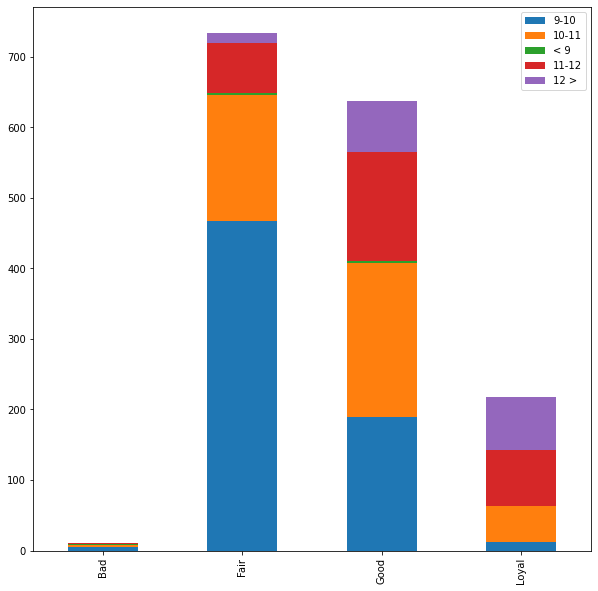

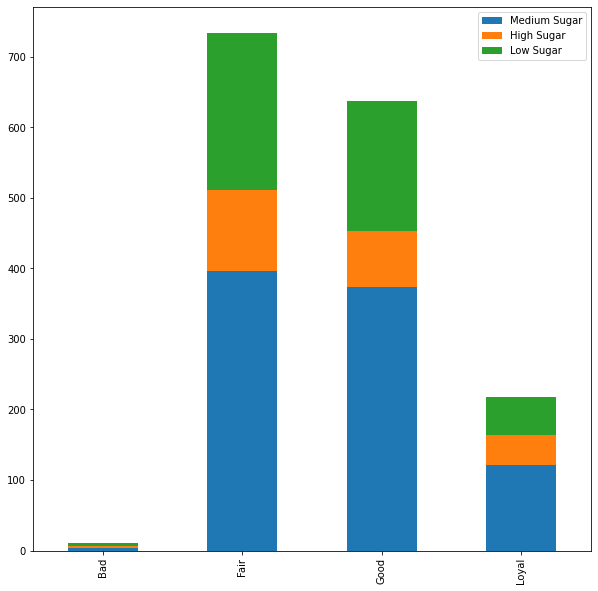

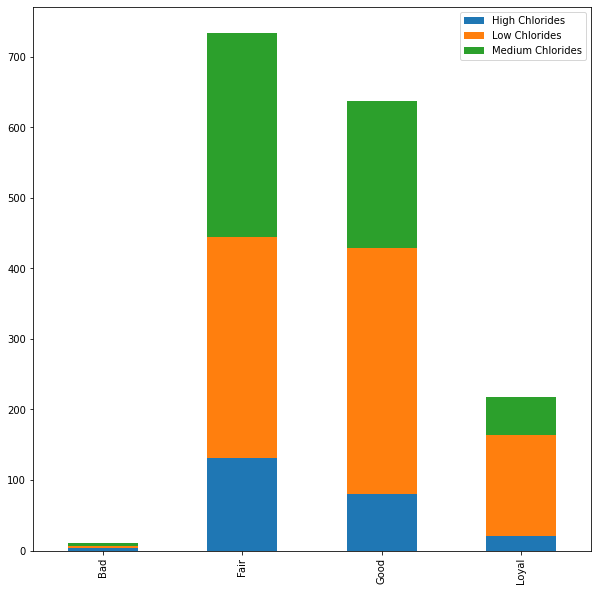

In [723]:
bar_chart('is_citric_acid')
bar_chart('alcoholClass')
bar_chart('sugarClass')
bar_chart('chloridesClass')

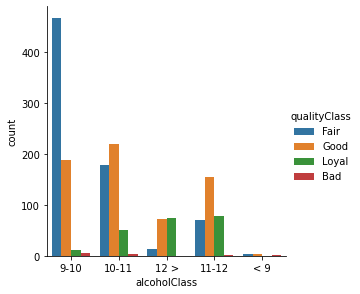

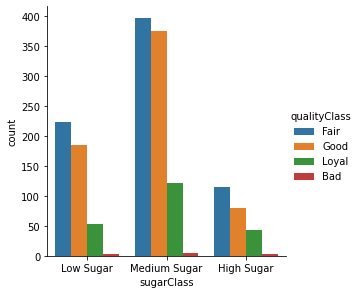

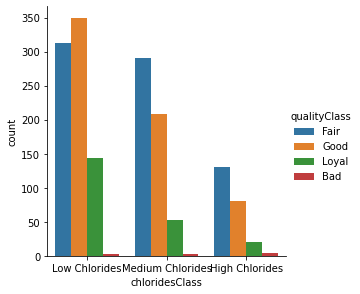

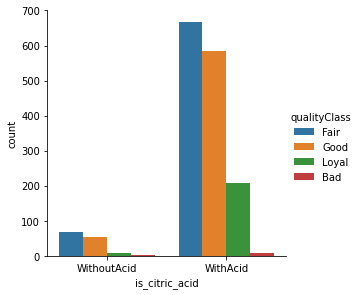

In [724]:
sns.catplot(x="alcoholClass", hue = 'qualityClass', data = redWineData,
            kind = 'count', height = 4)

sns.catplot(x="sugarClass", hue = 'qualityClass', data = redWineData,
            kind = 'count', height = 4)

sns.catplot(x="chloridesClass", hue = 'qualityClass', data = redWineData,
            kind = 'count', height = 4)

sns.catplot(x="is_citric_acid", hue = 'qualityClass', data = redWineData,
            kind = 'count', height = 4)

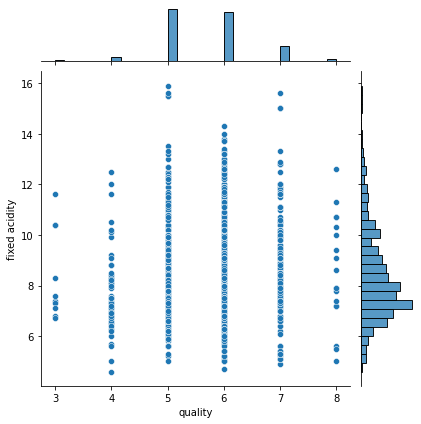

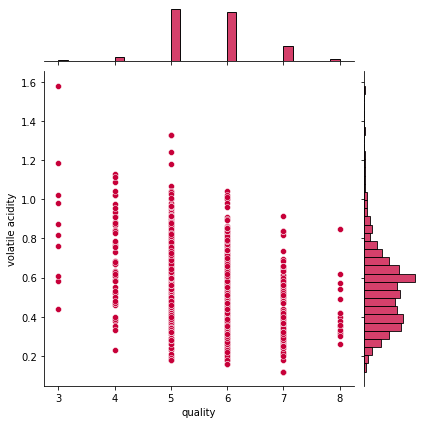

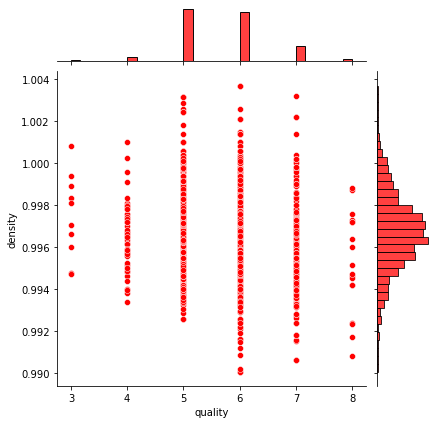

In [725]:
sns.jointplot(x="quality", y = "fixed acidity", data = redWineData)
sns.jointplot(x="quality", y = "volatile acidity", data = redWineData, color='#C70039')
sns.jointplot(x="quality", y = "density", data = redWineData, color='Red',)

In [726]:
def box_plot(xfeature, yfeature):
    fig, ax = mt.subplots(figsize=(10,6))
    box = sns.boxplot(x=xfeature,y=yfeature, hue="is_citric_acid", data=redWineData)
    fig.subplots_adjust(bottom=0.2)
    mt.tight_layout()

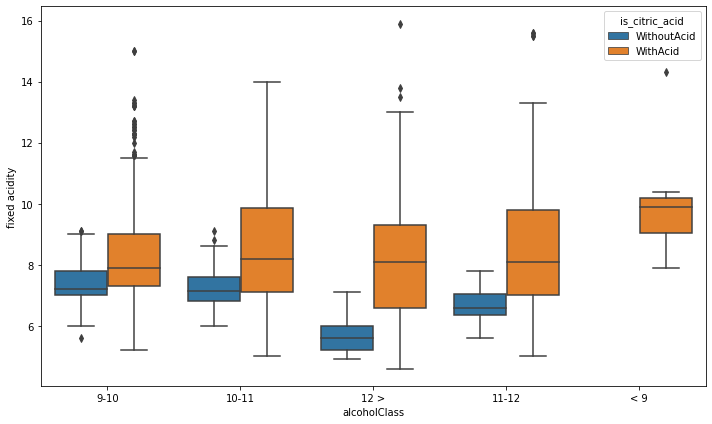

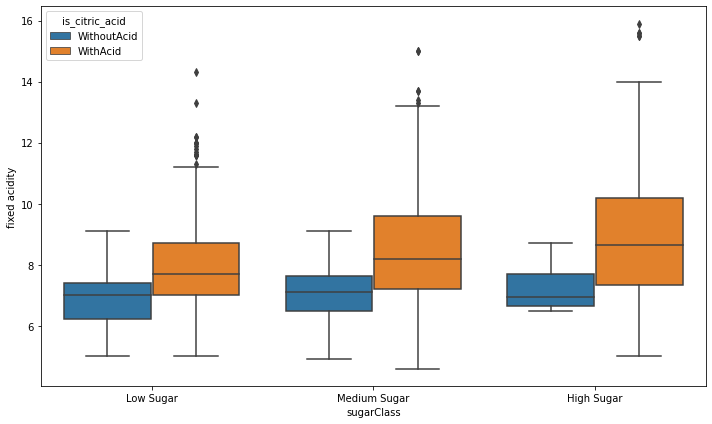

In [727]:
box_plot('alcoholClass', 'fixed acidity')
box_plot('sugarClass', 'fixed acidity')

In [728]:
# mt.figure(figsize=(10,4))
# color = {1:'blue', 0:'red'}
# mt.scatter(redWineData['alcohol'],redWineData['fixed acidity'], c = redWineData['qualityClass'].apply(lambda x: color[x]),alpha=0.5)
# mt.title('Alcohol Vs Sugar')
# mt.xlabel("Alcohol Category")
# mt.ylabel("Residual Sugar Category")
# mt.show

c:\users\norov\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\norov\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\norov\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

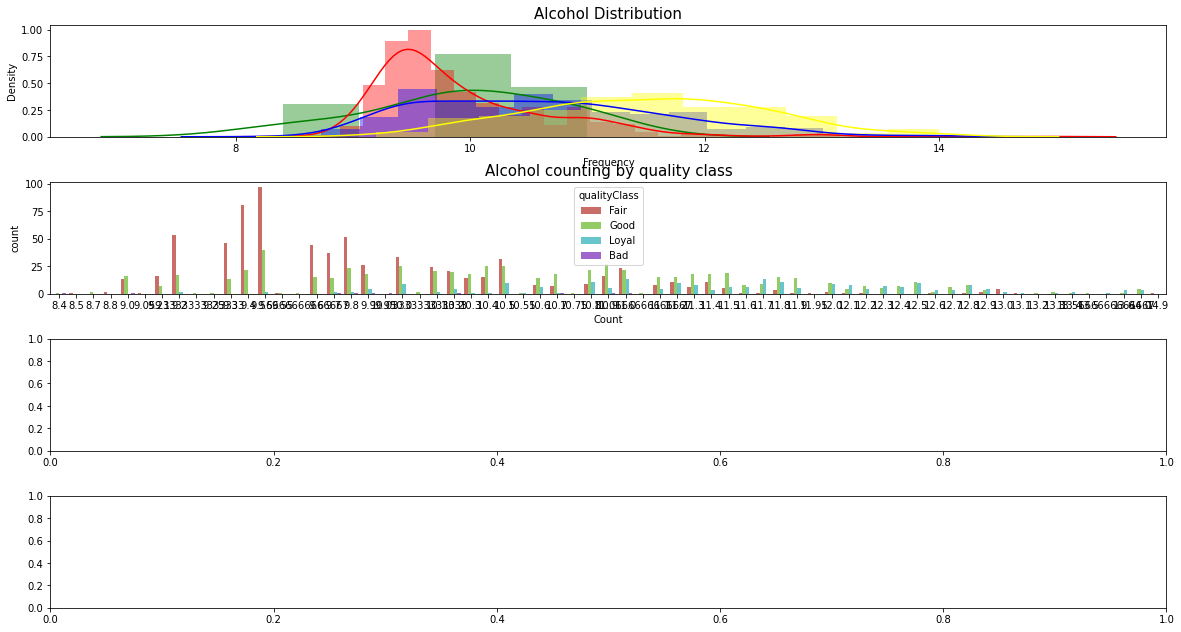

In [729]:
data_bad = redWineData[redWineData["qualityClass"] == 'Bad']
data_fair = redWineData[redWineData["qualityClass"] == 'Fair']
data_good = redWineData[redWineData["qualityClass"] == 'Good']
data_loyal = redWineData[redWineData["qualityClass"] == 'Loyal']
fig, ax = mt.subplots(nrows=4, figsize=(20,12))
mt.subplots_adjust(hspace = 0.4, top = 0.8)
g1 = sns.distplot(data_bad["alcohol"], ax=ax[0],color="g")
g1 = sns.distplot(data_fair["alcohol"], ax=ax[0],color='r')
g1 = sns.distplot(data_good["alcohol"], ax=ax[0],color='blue')
g1 = sns.distplot(data_loyal["alcohol"], ax=ax[0],color='yellow')
g1.set_title("Alcohol Distribution", fontsize=15)
g1.set_xlabel("Alcohol")
g1.set_xlabel("Frequency")
g2 = sns.countplot(x="alcohol",data=redWineData,
palette="hls", ax=ax[1],
hue = "qualityClass")
g2.set_title("Alcohol counting by quality class", fontsize=15)
g2.set_xlabel("Alcohol classification")
g2.set_xlabel("Count")
mt.show()

In [730]:
#SCALING VALUES

In [731]:
numvars = ['pH', 'fixed acidity', 'volatile acidity', 'free sulfur dioxide',
'total sulfur dioxide', 'density', 'sulphates']
# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(redWineData[numvars])
                           ,columns = numvars)
numdata_std['binaryQualityClass'] = redWineData['binaryQualityClass']

In [732]:
#ENCODING CATEGORICAL FEATURES

In [733]:
from collections import defaultdict
#categorical variables labels
catvars = ['alcoholClass', 'sugarClass', 'chloridesClass', 'qualityClass','is_citric_acid']
d = defaultdict(LabelEncoder)
# Encoding the variable
lecatdata = redWineData[catvars].apply(lambda x: d[x.name].fit_transform(x))
# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", redWineData[catvars[x]].unique())
    print(catvars[x],": ", lecatdata[catvars[x]].unique())
#One hot encoding, create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(redWineData[catvars])

alcoholClass :  ['9-10' '10-11' '12 >' '11-12' '< 9']
alcoholClass :  [3 0 2 1 4]
sugarClass :  ['Low Sugar' 'Medium Sugar' 'High Sugar']
sugarClass :  [1 2 0]
chloridesClass :  ['Low Chlorides' 'Medium Chlorides' 'High Chlorides']
chloridesClass :  [1 2 0]
qualityClass :  ['Fair' 'Good' 'Loyal' 'Bad']
qualityClass :  [1 2 3 0]
is_citric_acid :  ['WithoutAcid' 'WithAcid']
is_citric_acid :  [1 0]


In [734]:
data_clean = pd.concat([dummyvars,numdata_std],axis=1)
print("Data shape:",data_clean.shape)
data_clean.info()

Data shape: (1599, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   alcoholClass_10-11               1599 non-null   uint8  
 1   alcoholClass_11-12               1599 non-null   uint8  
 2   alcoholClass_12 >                1599 non-null   uint8  
 3   alcoholClass_9-10                1599 non-null   uint8  
 4   alcoholClass_< 9                 1599 non-null   uint8  
 5   sugarClass_High Sugar            1599 non-null   uint8  
 6   sugarClass_Low Sugar             1599 non-null   uint8  
 7   sugarClass_Medium Sugar          1599 non-null   uint8  
 8   chloridesClass_High Chlorides    1599 non-null   uint8  
 9   chloridesClass_Low Chlorides     1599 non-null   uint8  
 10  chloridesClass_Medium Chlorides  1599 non-null   uint8  
 11  qualityClass_Bad                 1599 non-null   uint8  
 1

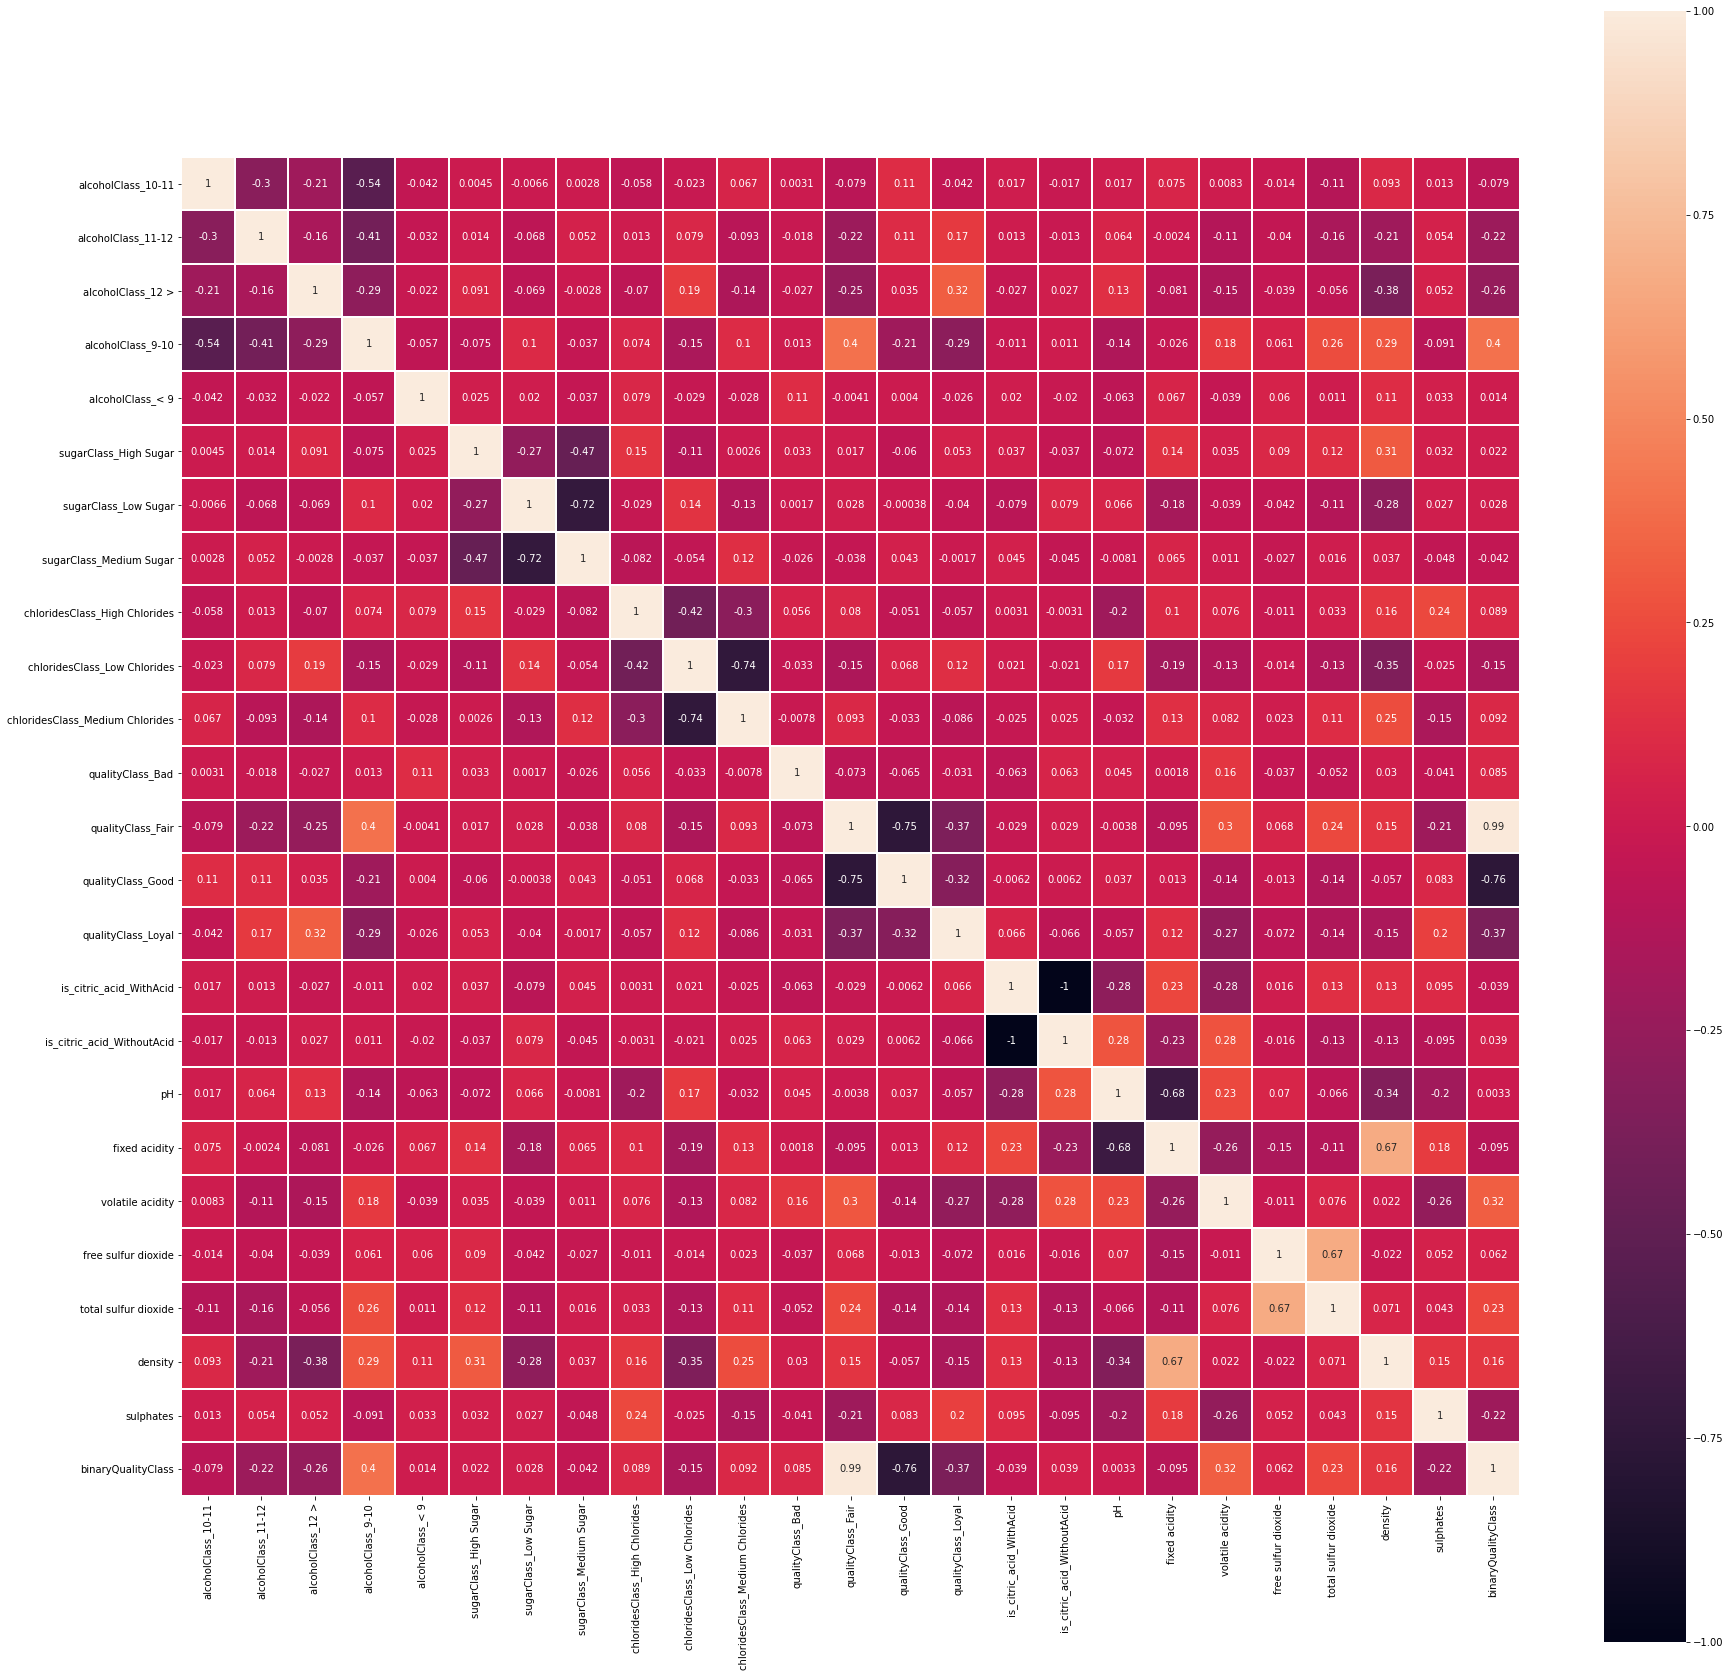

In [735]:
mt.figure(figsize=(30,30))
sns.heatmap(data_clean.corr(),linewidths=0.1,vmax=1.0,
square=True, linecolor='white', annot=True)
mt.show()


In [736]:
#Splitting data into train & test
X_clean = data_clean.drop('binaryQualityClass', axis=1)
y_clean = data_clean['binaryQualityClass']
X_train, X_test, y_train, y_test = train_test_split(X_clean,y_clean,test_size=0.2,
                                                    random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1279, 24)
(1279,)
(320, 24)
(320,)


In [737]:
#EVALUATION FUNCTIONS

In [779]:
# Function for evaluation reports
def get_eval1(clf, X,y):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X, y, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X, y, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X, y, cv=2, scoring='roc_auc')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(),
    scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(),
    scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(),
    scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(),
    scores4.std()))
    return

def get_eval2(clf, X_train, y_train,X_test, y_test):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_test, y_test, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X_test, y_test, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X_test, y_test, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X_test, y_test, cv=2, scoring='roc_auc')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(),
    scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(),
    scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(),
    scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(),
    scores4.std()))
    return


# Function to get roc curve
def get_roc(y_test, y_pred):


    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    mt.figure()
    lw = 2
    mt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    mt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    mt.xlim([0.0, 1.0])
    mt.ylim([0.0, 1.0])
    mt.xlabel('False Positive Rate')
    mt.ylabel('True Positive Rate')
    mt.title('Receiver operating characteristic')
    mt.legend(loc="upper left")
    mt.show()
    return


def get_lcurve(train_scores, test_scores):


    mt.figure(figsize=(12, 5))
    p = sns.lineplot(range(1, 100), train_scores, marker='*', label='Train Score')
    p = sns.lineplot(range(1, 100), test_scores, marker='o', label='Test Score')
    return


# Function to get Max test score
def get_max_score(test_scores2):


    max_test_score = max(test_scores2)
    test_scores_ind = [i1 for i1, v in enumerate(test_scores2) if v == max_test_score]
    print('Max test score {} % and k = {}'.format(max_test_score * 100, str(test_scores_ind[0])))
    return

# Function to get error rate
def get_err_rate(error, erange):


    mt.figure(figsize=(12, 6))
    mt.plot(erange, error, color='red', linestyle='dashed', marker='o',
             markerfacecolor='blue', markersize=10)
    mt.title('Error Rate K Value')
    mt.xlabel('Value of K for KNN')
    mt.ylabel('Mean Error')
    return
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):


    if axes is None:
        _, axes = mt.subplots(1, 3, figsize=(20, 5))
    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")
    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    return mt

In [739]:
#Model selection
from sklearn.neighbors import KNeighborsClassifier
error = []
train_scores = []
test_scores = []
# Calculating error for K values between 1 and 100
for i in range (1, 100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train,y_train))
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    test_scores.append(knn.score(X_test,y_test))

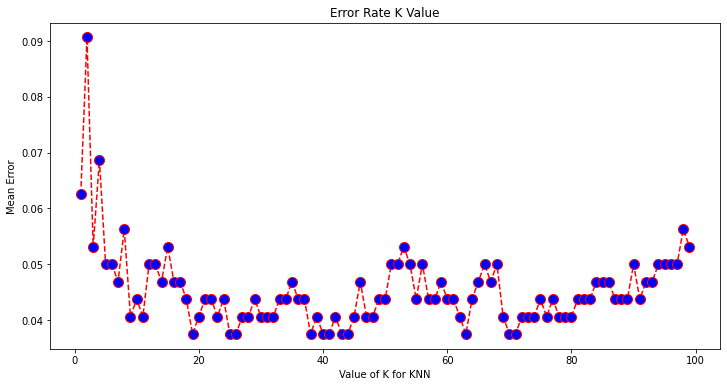

In [740]:
get_err_rate( error, range(1, 100))

Max test score 96.25 % and k = 18


c:\users\norov\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\norov\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


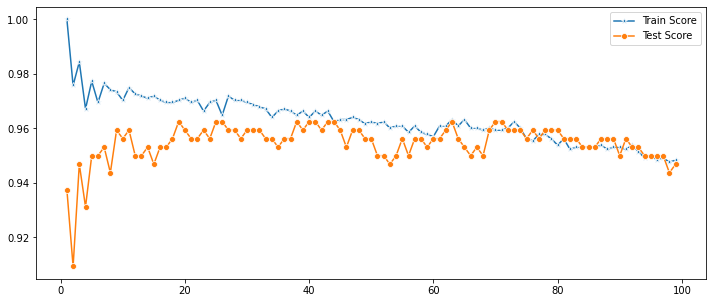

In [783]:
get_max_score(test_scores)
get_lcurve(train_scores,test_scores)


In [ ]:
#ROC Curves and AUC

75      1
1283    0
408     0
1281    0
1118    0
       ..
890     1
146     1
1551    1
1209    0
1220    0
Name: binaryQualityClass, Length: 320, dtype: int32


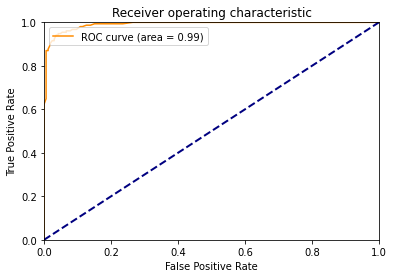

Cross Validation Accuracy: 0.93 (+/- 0.01)
Cross Validation Precision: 0.91 (+/- 0.02)
Cross Validation Recall: 0.93 (+/- 0.00)
Cross Validation roc_auc: 0.98 (+/- 0.01)
------------------------------
Cross Validation Accuracy: 0.85 (+/- 0.07)
Cross Validation Precision: 0.92 (+/- 0.08)
Cross Validation Recall: 0.77 (+/- 0.06)
Cross Validation roc_auc: 0.94 (+/- 0.05)


In [784]:
#print(X_test)
print(y_test)
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
get_roc(y_test, y_pred_proba)
get_eval1(knn,X_clean,y_clean)
print("-"*30)
get_eval2(knn,X_train,y_train,X_test, y_test)

In [ ]:
param_grid = {'n_neighbors':np.arange(1,100)}
knn1 = KNeighborsClassifier()
knn_cv= GridSearchCV(knn1,param_grid,cv=5, scoring='roc_auc')
knn_cv.fit(X_clean,y_clean)
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

In [ ]:
# X = redWineData.drop(columns=['quality'])
# y = redWineData['quality']
#
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
#
# wineEvaluateModel = DecisionTreeClassifier()
# wineEvaluateModel.fit(X_train,y_train)
# prediction = wineEvaluateModel.predict(X_test)
# prediction
# score = accuracy_score(y_test,prediction)
# score
#

In [ ]:
# #SNN model implementation
#

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
#
# knn = KNeighborsClassifier(n_neighbors=7)
# knn.fit(X_train, y_train)
# predict1 = knn.predict(X_test)
# score1 = accuracy_score(y_test, predict1)
# score
#

In [ ]:
# from sklearn import svm
#
# svmModel = svm.SVC()
# svmModel.fit(X_train, y_train)
# predictSVM = svmModel.predict(X_test)
#
# scoreSVM = accuracy_score(y_test, predictSVM)
# print(scoreSVM)
#

In [ ]:
# jupyter nbconvert ./notebooks/WineQualityPrediction.ipynb --to latex
#
#

In [ ]:
# pip install nbconvert
